# The Experiment
This experiment uses custom modules in the *backend* folder, which have been specifically developed for this third-year lab. This notebook works directly with the **13 TeV 2025 ATLAS Open Data**. 

Please run the cell below to install the required packages. You will need to do this **each time you start the server**.

In [1]:
!pip install atlasopenmagic
!pip install pyarrow==20.0.0 awkward==2.8.5
from atlasopenmagic import install_from_environment
install_from_environment(environment_file="environment.yml")

  Using cached atlasopenmagic-1.2.0-py3-none-any.whl.metadata (8.6 kB)
Using cached atlasopenmagic-1.2.0-py3-none-any.whl (16 kB)
  Using cached pyarrow-20.0.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (3.3 kB)
Using cached pyarrow-20.0.0-cp312-cp312-manylinux_2_28_x86_64.whl (42.3 MB)
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 19.0.0
    Uninstalling pyarrow-19.0.0:
      Successfully uninstalled pyarrow-19.0.0
Installing packages: ['aiohttp>=3.9.5', 'atlasopenmagic', 'awkward==2.8.5', 'awkward-pandas>=2023.8.0', 'coffea~=0.7.0', 'hist>=2.8.0', 'ipykernel>=6.29.5', 'jupyter>=1.0.0', 'lmfit>=1.3.2', 'matplotlib>=3.9.1', 'metakernel>=0.30.2', 'notebook>=7', 'numpy>=1.26.4', 'pandas>=2.2.2', 'papermill>=2.6.0', 'pip>=24.2', 'scikit-learn>=1.5.1', 'uproot>=5.3.10', 'uproot3>=3.14.4', 'fsspec-xrootd>=0.5.1', 'jupyterlab_latex>=3.1.0', 'vector>=1.4.1']
  Using cached coffea-0.7.30-py2.py3-none-any.whl.metadata (9.6 kB)
  Using cached numpy-2.3.2-cp312-cp31

Next, run the cell below to import the required modules and functions for the experiment. Repeat this step **every time you restart the kernel**.

In [2]:
import os
import re
import awkward as ak 
import vector
import time
import datetime
from zoneinfo import ZoneInfo
import uproot
import glob
import numpy as np
import hist
from hist import Hist
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator # for minor ticks
import sys
sys.path.append('../')
from backend import analysis_uproot, Dids_dict, validSkims, plot_stacked_hist, plot_histograms, analysis_read_parquet, plot_errorbars

Active release set to: 2025e-13tev-beta. Metadata cache cleared.


## Accessing Data Samples
Data samples stored in the *backend* folder can be accessed using `skim` **and** a *string code*, passed to the `analysis_uproot` function. The key `skim` and string codes are listed below:  

#### `Skim` (Final-State Filters)
* `'2to4lep'` - Events with two to four leptons, each with at least 7 GeV of transverse momentum $p_T$
* `'GamGam'` - Events with at least two photons, each with at least 25 GeV of $p_T$

#### String Codes
* `'Data'` - Real data
* `'Zee'` - Simulated $Z \rightarrow e^+e^-$ events
* `'Zmumu'` - Simulated $Z \rightarrow \mu^+\mu^-$ events
* `'Hyy'` - Simulated $H \rightarrow \gamma \gamma$ events

> **Note**: The string code for real data is always `'Data'`, regardless of the `skim` used.

To combine multiple datasets, combine the string codes using `'+'`. For example, if you would like to combine the $Z \rightarrow \mu^+\mu^-$ and $Z \rightarrow e^+e^-$ datasets, use the string code `'Zee+Zmumu'`.

All available `skim` can be viewed with `validSkims`, and all string codes with `Dids_dict.keys()`.

In [3]:
validSkims

['2to4lep',
 '2muons',
 'GamGam',
 'exactly4lep',
 '1LMET30',
 '3J1LMET30',
 '2J2LMET30',
 '2bjets',
 '3lep',
 'exactly3lep',
 '4lep']

In [4]:
Dids_dict.keys()

dict_keys(['Zee', 'Zmumu', 'Ztautau', 'VBF_Zee', 'VBF_Zmumu', 'VBF_Ztautau', 'Wenu', 'Wmunu', 'Wtaunu', 'VBF_Wenu', 'VBF_Wmunu', 'VBF_Wtaunu', 'ttbar', 'VV4l', 'm10_40_Zee', 'm10_40_Zmumu', 'ggF_Hyy', 'VBF_Hyy', 'WpH_Hyy', 'WmH_Hyy', 'ZH_Hyy', 'ggZH_Hyy', 'ttH_Hyy', 'ggH_H4l', 'VBF_H4l', 'ttH_H4l', 'ggZH_H4l', 'ZH_H4l', 'WpH_H4l', 'WmH_H4l', 'VBF_Zll', 'm10_40_Zll', 'Wlepnu', 'VBF_Wlepnu', 'Hyy', 'H4l'])

To use `analysis_uproot`, the following arguments must be provided:
- `string_code_dict` (*dict*) : Maps dataset labels to string codes
  - **Keys**: Labels used in the output dictionary of Awkward Arrays  
        - Must include 'Data' in the key for real data. When detected, `analysis_uproot` will skip weight calculation for that sample to reduce memory usage.
  - **Values**: The corresponding string codes
  - **Example**:
    ```
    string_code_dict = {
        'Data' : 'Data',
        'Signal Zee' : 'Zee',
        'Background Wenu+Wmunu' : 'Wenu+Wmunu'
    }
    ```
- `skim` (*str*) e.g. `'2to4lep'`
- `luminosity` (*float*) : Integrated luminosity in fb⁻¹, e.g. `36.6`.
- `fraction` (*float*) : Fraction of each dataset to read, e.g. `0.1` for 10%
- `read_variables` (*list of str*) : Names of ROOT branches to read
- `save_variables`(*list of str*) : Variables to keep in memory or write to disk

Optional argument:
- `cut_function` (*callable*): Function that receives an argument and returns it. Can be used to:
    - Apply selection cuts
    - Compute derived variables using the data in `read_variables`, e.g. invariant mass
- `sample_path` (*str*) : Path to the sample files, either for accessing existing files or downloading new ones (default: `'../backend/datasets'`)
- `write_parquet` (*bool*) : Set to `True` to write output to Parquet files
- `output_directory` (*str or None*) :
   - Directory where files will be saved
   - If `None`, a unique folder in `output/` will be created using the current date and time
- `write_txt` (*bool*) : Set to `True` to write a summary log of the run
- `txt_filename` (*str or None*) : Filename for the summary log. If not provided, a unique file will be created in the `txt/` folder.
- `return_output` (*bool*)
  - `True` (default) : Returns the output dictionary of Awkward Arrays
  - `False` : Nothing is returned (saves memory when only writing to disk)

In [5]:
string_code_dict = {
    'Data' : 'Data',
    'Signal Zee' : 'Zee',
    'Signal Zmumu' : 'Zmumu',
    'Background Wenu+Wmunu' : 'Wenu+Wmunu',
    'Background VV4l+H4l' : 'VV4l+H4l'
}
skim = '2to4lep'
luminosity = 36.6
fraction = 0.01
read_variables = ['lep_n', 'lep_pt',
                 'lep_eta', 'lep_phi', 'lep_e']
save_variables = read_variables

def pt_30_cut(data):
    data = data[data['lep_n'] == 2]
    
    pt_cut = (data['lep_pt'][:, 0] > 30) & (data['lep_pt'][:, 1] > 30)
    data = data[pt_cut]
    # Define four momentum
    four_momentum = vector.zip({
        'pt': data['lep_pt'],
        'eta' : data['lep_eta'],
        'phi' : data['lep_phi'],
        'E' : data['lep_e']
    })
    # Add the 4-momentum of the two leptons in each event and get the 
    # invariant mass using .M
    data['mass'] = (four_momentum[:, 0] + four_momentum[:, 1]).M
    return data


pt30_data = analysis_uproot(skim, string_code_dict, luminosity, fraction, 
                read_variables, save_variables, cut_function=pt_30_cut)
pt30_data

Fetching and caching all metadata for release: 2025e-13tev-beta...
Successfully cached 374 datasets.
../backend/datasets
File ODEO_FEB2025_v0_2to4lep_data15_periodD.2to4lep.root already exists in ../backend/datasets/2to4lep/Data. Skipping download.
File ODEO_FEB2025_v0_2to4lep_data15_periodE.2to4lep.root already exists in ../backend/datasets/2to4lep/Data. Skipping download.
File ODEO_FEB2025_v0_2to4lep_data15_periodF.2to4lep.root already exists in ../backend/datasets/2to4lep/Data. Skipping download.
File ODEO_FEB2025_v0_2to4lep_data15_periodG.2to4lep.root already exists in ../backend/datasets/2to4lep/Data. Skipping download.
File ODEO_FEB2025_v0_2to4lep_data15_periodH.2to4lep.root already exists in ../backend/datasets/2to4lep/Data. Skipping download.
File ODEO_FEB2025_v0_2to4lep_data15_periodJ.2to4lep.root already exists in ../backend/datasets/2to4lep/Data. Skipping download.
File ODEO_FEB2025_v0_2to4lep_data16_periodA.2to4lep.root already exists in ../backend/datasets/2to4lep/Data. Sk

{'Data': <Array [{lep_n: 2, lep_pt: [...], ...}, ...] type='434083 * {lep_n: int32, ...'>,
 'Signal Zee': <Array [{lep_n: 2, lep_pt: [...], ...}, ...] type='300100 * {lep_n: int32, ...'>,
 'Signal Zmumu': <Array [{lep_n: 2, lep_pt: [...], ...}, ...] type='313943 * {lep_n: int32, ...'>,
 'Background Wenu+Wmunu': <Array [{lep_n: 2, lep_pt: [...], ...}, ...] type='17515 * {lep_n: int32, l...'>,
 'Background VV4l+H4l': <Array [{lep_n: 2, lep_pt: [...], ...}, ...] type='1654 * {lep_n: int32, le...'>}

You can simply set `write_parquet = True` if you would like to write data to disk. It is recommended to set `return_output = False` to reduce memory usage if you choose to save output to Parquet files.

In [6]:
def pt_20_cut(data):
    data = data[data['lep_n'] == 2]

    pt_cut = (data['lep_pt'][:, 0] > 20) & (data['lep_pt'][:, 1] > 20)
    data = data[pt_cut]
    
    # Define four momentum
    four_momentum = vector.zip({
        'pt': data['lep_pt'],
        'eta' : data['lep_eta'],
        'phi' : data['lep_phi'],
        'E' : data['lep_e']
    })
    # Add the 4-momentum of the two leptons in each event and get the 
    # invariant mass using .M
    data['mass'] = (four_momentum[:, 0] + four_momentum[:, 1]).M
    return data

output_dir = 'output/pt20_cut'
pt20_data = analysis_uproot(skim, string_code_dict, luminosity, fraction, 
                read_variables, save_variables, cut_function=pt_20_cut,
                write_txt=False, txt_filename=None,
                write_parquet=True, output_directory=output_dir,
                return_output=False)

../backend/datasets
File ODEO_FEB2025_v0_2to4lep_data15_periodD.2to4lep.root already exists in ../backend/datasets/2to4lep/Data. Skipping download.
File ODEO_FEB2025_v0_2to4lep_data15_periodE.2to4lep.root already exists in ../backend/datasets/2to4lep/Data. Skipping download.
File ODEO_FEB2025_v0_2to4lep_data15_periodF.2to4lep.root already exists in ../backend/datasets/2to4lep/Data. Skipping download.
File ODEO_FEB2025_v0_2to4lep_data15_periodG.2to4lep.root already exists in ../backend/datasets/2to4lep/Data. Skipping download.
File ODEO_FEB2025_v0_2to4lep_data15_periodH.2to4lep.root already exists in ../backend/datasets/2to4lep/Data. Skipping download.
File ODEO_FEB2025_v0_2to4lep_data15_periodJ.2to4lep.root already exists in ../backend/datasets/2to4lep/Data. Skipping download.
File ODEO_FEB2025_v0_2to4lep_data16_periodA.2to4lep.root already exists in ../backend/datasets/2to4lep/Data. Skipping download.
File ODEO_FEB2025_v0_2to4lep_data16_periodB.2to4lep.root already exists in ../backen

## Reading Parquet Files
You can read the files saved by `analysis_uproot` using the `analysis_read_parquet` function. Before reading large datesets, it is recommended to restart the kernel to clear memory. 

In [7]:
read_directory = 'output/pt20_cut'
read_variables = ['lep_pt', 'mass']
pt20_data = analysis_read_parquet(read_variables, read_directory, 
                                  subdirectory_names=None,
                                  fraction=1, cut_function=None, 
                                  write_parquet=False,
                                  output_directory=None, return_output=True)
pt20_data

Elapsed time = 0.7s


{'Signal Zmumu x1': <Array [{lep_pt: [...], mass: 91.7, ...}, ...] type='451974 * {lep_pt: var ...'>,
 'Signal Zee x1': <Array [{lep_pt: [...], mass: 81.6, ...}, ...] type='425569 * {lep_pt: var ...'>,
 'Data x1': <Array [{lep_pt: [...], mass: 96.5}, ...] type='672863 * {lep_pt: var * flo...'>,
 'Background Wenu+Wmunu x1': <Array [{lep_pt: [...], mass: 32.4, ...}, ...] type='26068 * {lep_pt: var *...'>,
 'Background VV4l+H4l x1': <Array [{lep_pt: [...], mass: 87.2, ...}, ...] type='3072 * {lep_pt: var * ...'>}

Similarly, you can also apply selection cuts and write filtered data to disk using `analysis_write_parquet`. Note that the function will create the dictionary keys by combining the subdirectory names with the `fraction`, separated by `' x'`.

## Plotting Stacked Histograms
The dictionary returned by `analysis_uproot` can be passed to `plot_stacked_hist` to plot stacked histograms.

Elapsed time = 1.9s


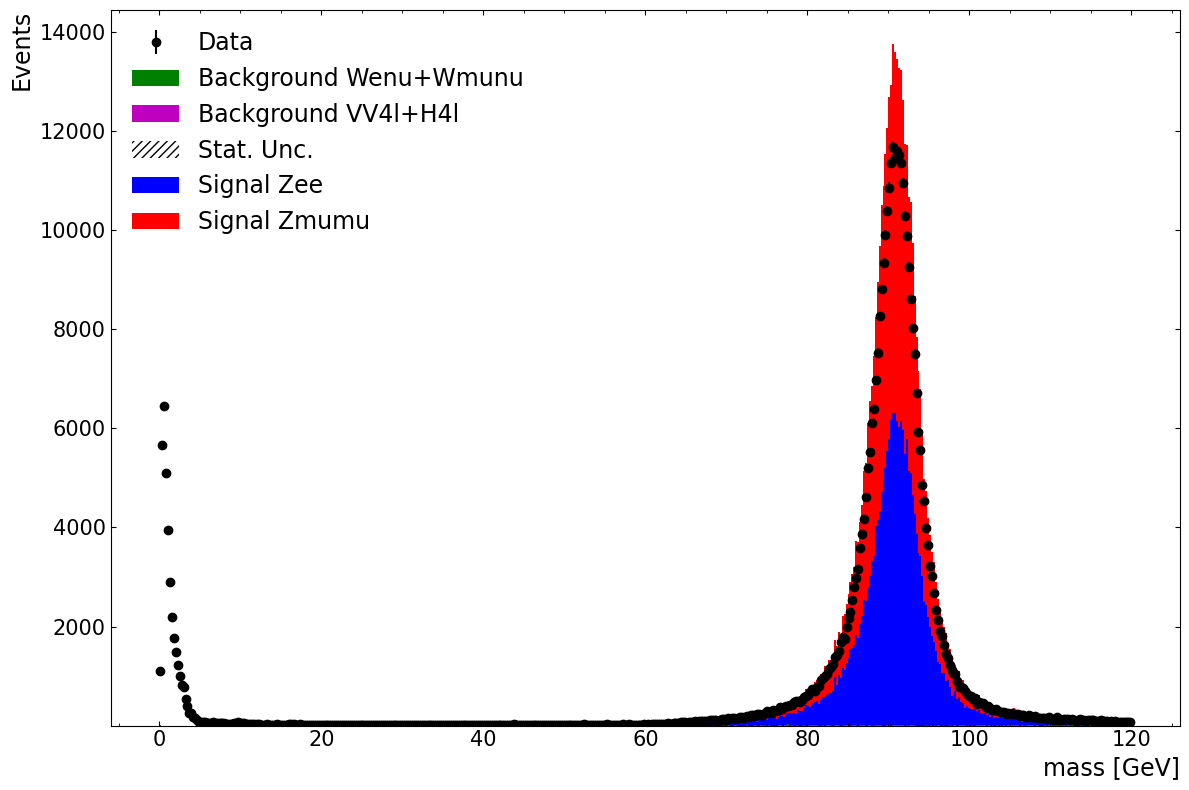

In [8]:
# Variable to plot on the x-axis
plot_variable = 'mass'

# Define plot appearance
color_list = ['k', 'b', 'r', 'g', 'm']
xmin, xmax = 0, 120 # Define histogram bin range and x-axis limits 
num_bins = 500 # Number of histogram bins
x_label = 'mass [GeV]' # x-axis label 

# Plot the histogram
fig, hists = plot_stacked_hist(pt30_data, plot_variable, color_list,
                               num_bins, xmin, xmax, x_label,
                               show_text=False, save_fig=False)

If you would like to plot many variables at once, you can use the `plot_histograms` function.

Elapsed time = 1.2s


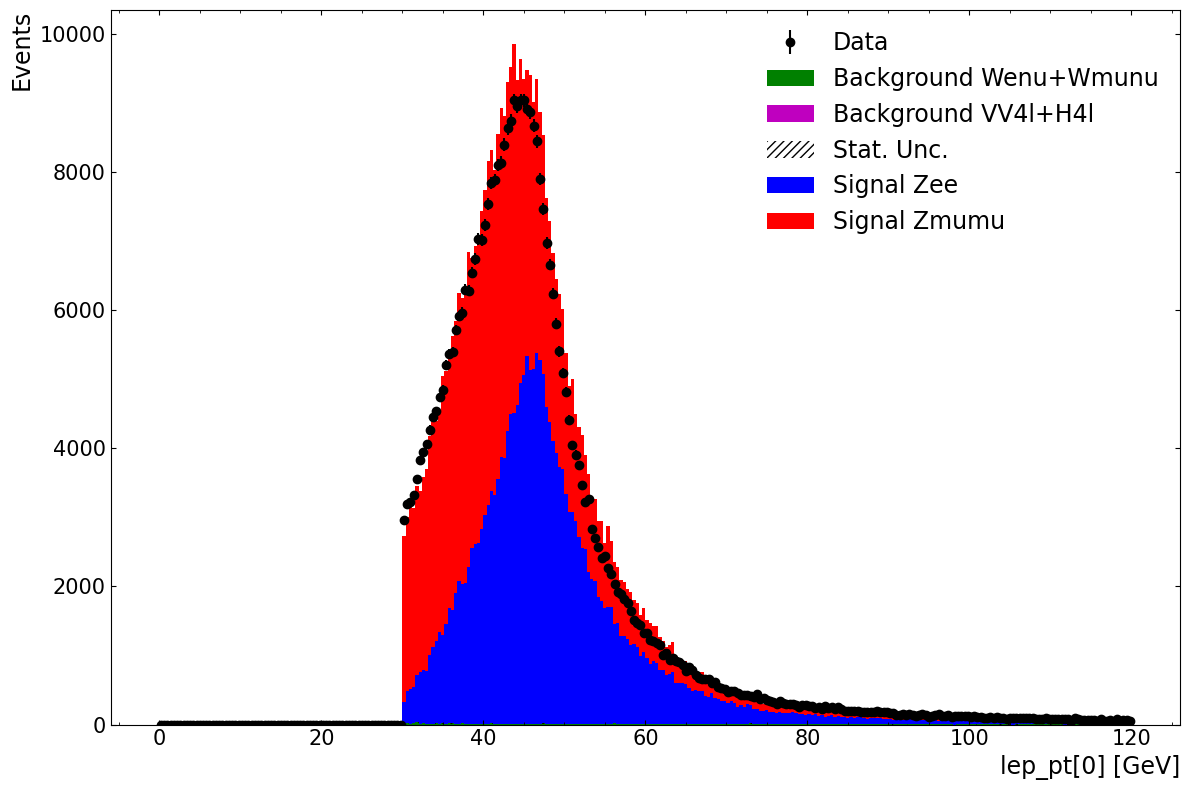

Elapsed time = 3.6s


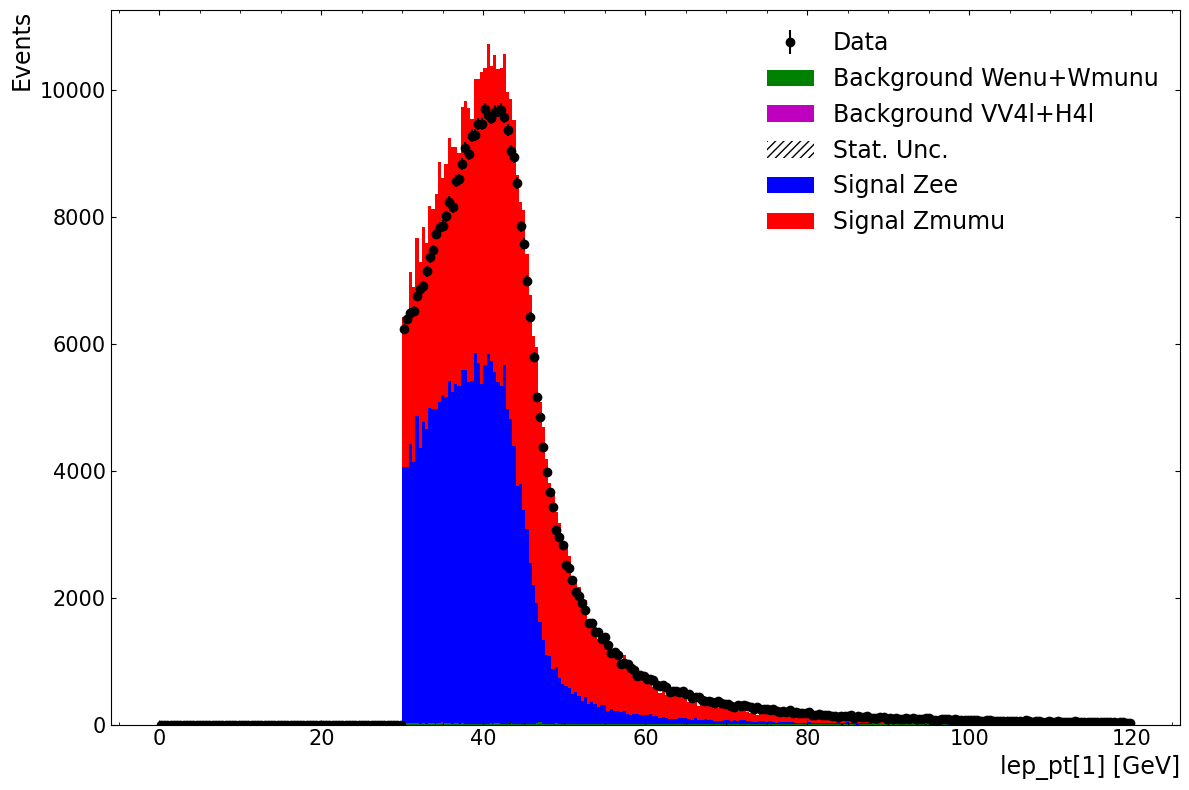

Elapsed time = 5.8s


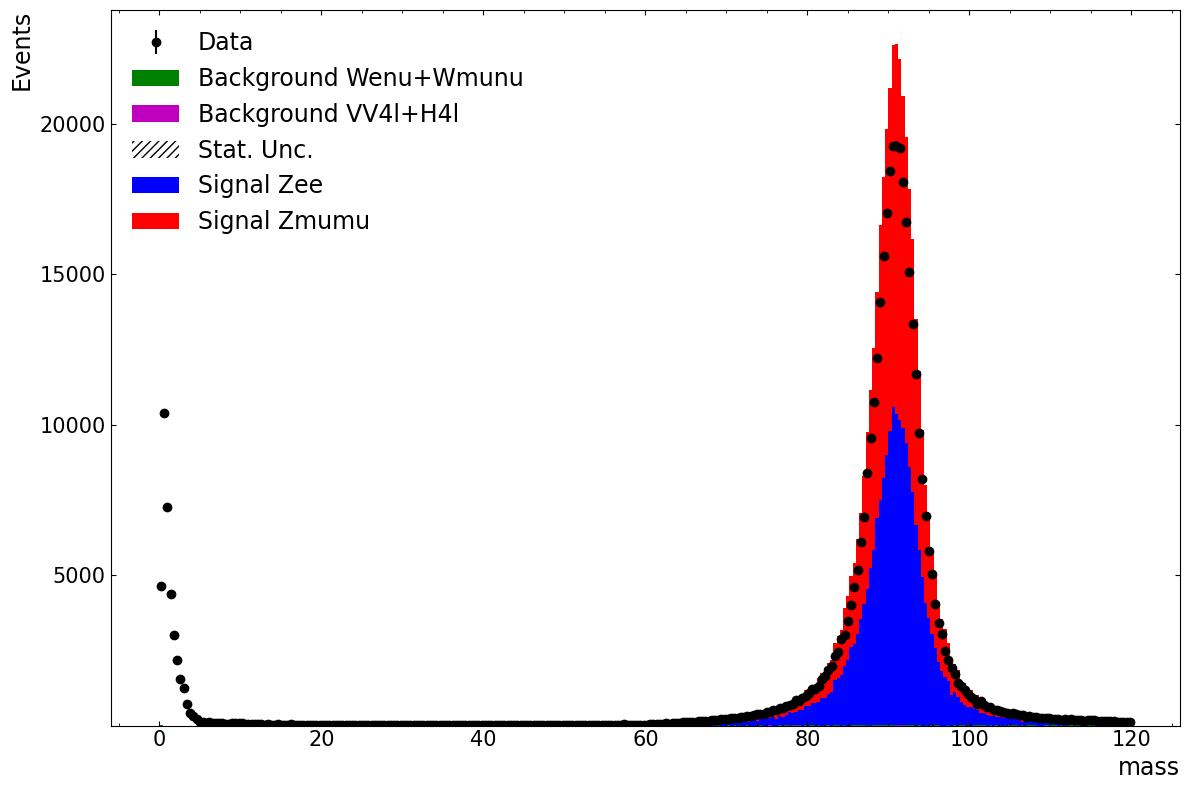

In [9]:
# Plot many variables at once 
plot_variables = ['lep_pt[0]', 'lep_pt[1]', 'mass']
xmin_xmax_list = (0, 120) # Bin range for all variables
# Define plot appearance
color_list = ['k', 'b', 'r', 'g', 'm']
num_bins_list = 300 
x_label_list = ['lep_pt[0] [GeV]', 'lep_pt[1] [GeV]', 'mass']

figure_list, hists_list = plot_histograms(pt30_data,
                                          plot_variables,
                                          color_list,
                                          xmin_xmax_list,
                                          num_bins_list,
                                          x_label_list)

In [ ]:
# You can use the Figure object returned by the function to save the figure as an image
figure_list[0].savefig('test.png', dpi=500)